# Reproduce the synthetic results plots related to a single flow: parameter distribution plot, flow value histograms and cumulative relative error plots

In [28]:
import scipy
import numpy as np
import torch
import torch.nn as nn
import scipy.spatial.distance as sdist
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import copy
import tikzplotlib
import os
import pandas as pd
import seaborn as sns

In [29]:
import src.dataprocessing as dataproc
import src.flow_models as flow_models
import src.utils
import src.experimentutils as experutils

In [30]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [31]:
def plot_mag_error_curves(gt_flow, add_mm_marker=False, xlim=(-1, 1), nsteps=100, **flows):
    fig, ax = plt.subplots()
    
    auc = {}

    thres = np.logspace(xlim[0], xlim[1], nsteps)
    for (name, flow), color_ in zip(flows.items(), default_colors):
        rel_error = np.maximum(np.abs(flow - gt_flow), 1e-6) / np.maximum(np.abs(gt_flow), 1e-6)
        median_rel_error = np.median(rel_error)

        lower_than_p = []
        for t in thres:
            p = (rel_error < t).sum() / len(rel_error)
            lower_than_p.append(p)

        auc[name] = np.trapz(y=lower_than_p, x=thres)
        if name == 'zeros':
            ax.plot(thres, 100 * np.asarray(lower_than_p), '--', color='k', label=name, alpha=0.76)
        else:
            ax.plot(thres, 100 * np.asarray(lower_than_p), label=name, color=color_)
            if add_mm_marker:
                ax.plot([median_rel_error, median_rel_error], [-5, 50], '--', color=color_, alpha=0.4)

    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('t')
    ax.set_ylabel('% rel. error $<$ t')
    if add_mm_marker:
        ax.plot([10**xlim[0], 10**xlim[1]], [50, 50], '--', color='k', alpha=0.4)
        
    ax.axis([10**xlim[0], 10**xlim[1], -5, 105])

    return fig, ax, auc

In [32]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Config setup and speficiation of synthetic data type

In [33]:
configs = src.utils.load_configs('data/default_configs.json')
train_config = configs['train_config']
eval_config = configs['eval_config']
init_config = configs['init_config']
hyperpara_config = configs['hyperpara_config']
loss_config = configs['loss_config']
baseline_hyperpara_config = configs['baseline_hyperpara_config']

eval_config.gt_num_emb_modes = 3
eval_config.gt_num_gate_modes = 3

init_config.embedding_dim = 2
init_config.embedding_init = 'auto-noise'
init_config.gates_init = 'zeros'
init_config.use_simple_gates = True

hyperpara_config.emb_grad_noise = src.utils.GradientNoise(False, 5, 0.005)
hyperpara_config.gates_grad_noise = src.utils.GradientNoise(False, 5, 0.005)
hyperpara_config.use_proportional_noise = True
hyperpara_config.embeddings_reg = src.utils.SheafFlowReg(nn.L1Loss(), 0.)
hyperpara_config.gates_reg = src.utils.SheafFlowReg(nn.L1Loss(), 0.)

loss_config.nu = 'auto'

In [34]:
graph_name = 'complete'  # Either 'cora', 'bitcoin' or 'complete'
distribution = 'multimodal' # Either 'multimodal' or 'unimodal'

figures_save_folder = f'figures/synthetic_analysis_updated/'
os.makedirs(figures_save_folder, exist_ok=True)

In [35]:
data_path = "data/"
if graph_name == 'cora':
    graph = dataproc.Graph.read_csv(os.path.join(data_path, "preprocessed_cora.csv"))
    node2vec_path = os.path.join(data_path, "trained_node2vec/node2vec_cora/node2vec_emb_0.pth")
elif graph_name == 'bitcoin':
    graph = dataproc.Graph.read_csv(os.path.join(data_path, "preprocessed_bitcoin.csv"))
    node2vec_path = os.path.join(data_path, "trained_node2vec/node2vec_bitcoin/node2vec_emb_0.pth")
elif graph_name == 'complete':
    graph = dataproc.complete_graph(num_nodes=40)
    node2vec_path = os.path.join(data_path, "trained_node2vec/node2vec_complete/node2vec_emb_0.pth")
else:
    raise ValueError(f"Unknown graph {graph_name}")
num_nodes = graph.num_vertices()

In [36]:
if distribution == 'multimodal':
    gt_node_embeddings_np, gt_gates_np, emb_comp_ids, gates_comp_ids = dataproc.sample_trade_scenario('2:2', num_nodes=num_nodes)
    gt_node_embeddings = torch.from_numpy(gt_node_embeddings_np.astype(np.float32))
    gt_gates = torch.from_numpy(gt_gates_np.astype(np.float32))

    gt_model = flow_models.SheafFlowPlusPlus(num_nodes=num_nodes, embedding_dim=2,
                                                   use_simple_gates=True,
                                                   embedding_init=gt_node_embeddings, gates_init=gt_gates, beta=1.)
elif distribution == 'unimodal':
    emb_scale = 100
    gates_scale = 1.

    gt_node_embeddings = src.utils.sample_student_t(num_nodes, init_config.embedding_dim, df=2, scale=emb_scale)
    gt_gates = src.utils.sample_student_t(num_nodes, init_config.embedding_dim, df=4, scale=gates_scale) - 2 * gates_scale
    
    gt_node_embeddings_np = gt_node_embeddings.cpu().numpy()
    gt_gates_np = gt_gates.cpu().numpy()
    
    emb_comp_ids = gates_comp_ids = np.zeros(len(gt_node_embeddings_np))

    gt_model = flow_models.SheafFlowPlusPlus(num_nodes=num_nodes, embedding_dim=init_config.embedding_dim,
                                                   use_simple_gates=True,
                                                   embedding_init=gt_node_embeddings, gates_init=gt_gates, beta=1.)

else:
    raise RuntimeError

# Prepare and train all the models

In [37]:
graph, flow_summary = dataproc.add_sheaf_flow(graph, gt_model)

In [38]:
device = torch.device('cuda')
model_factory = experutils.ModelFactory.create(graph, device, loss_config=loss_config)


In [39]:
all_models, all_res = experutils.fit_synthetic_models(model_factory, 
                                                      feature_sets=("engi_feat", "node2vec"),
                                                      model_types=("dnn2",), 
                                                      node2vec_path=node2vec_path, 
                                                      powerfactor=10,
                                                      train_config=train_config, 
                                                      eval_config=eval_config, 
                                                      hyperpara_config=hyperpara_config, 
                                                      init_config=init_config, 
                                                      baseline_hyperpara_config=baseline_hyperpara_config)
                                                   

-----------------
Iteration number 0
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 7.96, 0.00
-----------------
Iteration number 1
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.57, 3.90
-----------------
Iteration number 2
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.08, 0.23
-----------------
Iteration number 3
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.02, 0.04
-----------------
Iteration number 4
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.01
-----------------
Iteration number 5
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 6
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 7
Updating goodness


In [40]:
pd.DataFrame(all_res)

,dnn2_engi_feat,dnn2_node2vec,gated,grad
val_median_mag_error,-1.315232,-1.036615,-2.230624,-6.207566e-01
val_within_scale_neg_1,0.660256,0.525641,0.935897,3.782051e-01
val_sign_agr,0.980769,0.942308,1.000000,9.935897e-01
val_within_1_mag,1.0,0.99359,1.000000,1.000000e+00
val_within_scale,0.942308,0.878205,1.000000,9.935897e-01
val_mean_mag_error,-1.254126,-0.952601,-2.267312,-8.514644e-01
val_rmse,2.821791,7.514585,0.670093,2.142947e+01
val_mae,1.739889,3.462571,0.287679,1.205239e+01
val_MeAE,0.78909,1.211672,0.057087,1.338409e+00
val_loss,0.161998,0.444085,0.003002,9.196044e-01


In [41]:
final_node_emb, final_gates = all_models['gated'].get_parameter_clones()
final_node_emb = final_node_emb.numpy()
final_gates = final_gates.numpy()

# Plot learned distributions

<IPython.core.display.Javascript object>


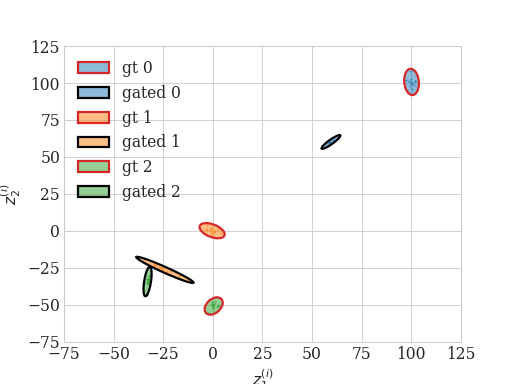

In [42]:
save_path = os.path.join(figures_save_folder, f"gt_model_emb_scatter_{graph_name}_{distribution}")
fig, ax = plt.subplots()

if distribution == 'multimodal':
    for i in range(3):
        group_gt = gt_node_embeddings_np[emb_comp_ids==i, :]
        sample = np.random.permutation(len(group_gt))[:1000]
        fill_color = matplotlib.colors.colorConverter.to_rgba(default_colors[i], alpha=.5)

        confidence_ellipse(group_gt[:, 0], group_gt[:, 1], ax,
                           facecolor=fill_color, edgecolor='tab:red', zorder=2,  lw=2, label="gt " + str(i))
        ax.scatter(group_gt[sample, 0], group_gt[sample, 1], s=1, color=default_colors[i], zorder=1, alpha=0.5)

        group_final = final_node_emb[emb_comp_ids==i, :]

        confidence_ellipse(group_final[:, 0], group_final[:, 1], ax,
                           facecolor=fill_color, edgecolor='k', zorder=2, lw=2, label="gated " + str(i))
        ax.scatter(group_final[sample, 0], group_final[sample, 1], s=1, color=default_colors[i], zorder=1, alpha=0.5)
elif distribution == 'unimodal':
    pass
#     sample = np.random.permutation(len(gt_node_embeddings_np))[:1000]
#     ax.scatter(gt_node_embeddings_np[sample, 0], gt_node_embeddings_np[sample, 1], s=24, color=default_colors[0], zorder=1, alpha=0.4)
#     ax.scatter(final_node_emb[sample, 0], final_node_emb[sample, 1], s=24, color=default_colors[1], zorder=1, alpha=0.4)

ax.legend()
ax.axis([-75, 125, -75, 125])
ax.set_xlabel(r"$z_1^{(i)}$")
ax.set_ylabel(r"$z_2^{(i)}$")


fig.savefig(save_path + ".pdf", bbox_inches='tight')
tikzplotlib.save(save_path + ".tex")

<IPython.core.display.Javascript object>


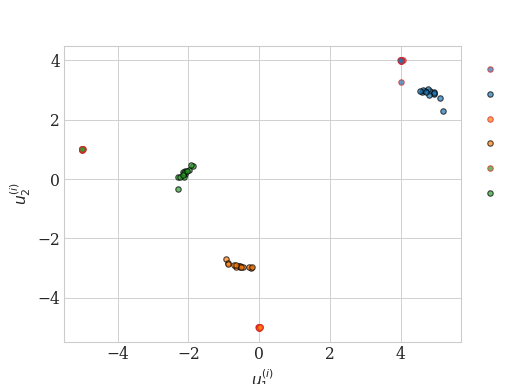

In [43]:
save_path = os.path.join(figures_save_folder, f"gt_model_gates_scatter_{graph_name}_{distribution}")
fig, ax = plt.subplots()

if distribution == 'multimodal':
    for i in range(3):
        group_gt = gt_gates_np[emb_comp_ids==i, :]
        fill_color = matplotlib.colors.colorConverter.to_rgba(default_colors[i], alpha=.5)
        sample = np.random.permutation(len(group_gt))[:1000]

    #     confidence_ellipse(group_gt[:, 0], group_gt[:, 1], ax,
    #                        facecolor=fill_color, edgecolor='tab:red', zorder=2,  lw=2, label="gt " + str(i)))
        ax.scatter(group_gt[sample, 0], group_gt[sample, 1], s=24, color=default_colors[i], 
                   zorder=1, alpha=0.7, label="gt " + str(i), edgecolors='tab:red', linewidths=1)

        group_final = final_gates[emb_comp_ids==i, :]

    #     confidence_ellipse(group_final[:, 0], group_final[:, 1], ax,
    #                        facecolor=fill_color, edgecolor='k', zorder=2, lw=2, label="gated " + str(i))))
        ax.scatter(group_final[sample, 0], group_final[sample, 1], s=24, color=default_colors[i], 
                   zorder=1, alpha=0.7, label="gated " + str(i), edgecolors='k', linewidths=1)
elif distribution == 'unimodal':
    pass
#     sample = np.random.permutation(len(gt_node_embeddings_np))[:1000]
#     ax.scatter(gt_gates_np[sample, 0], gt_gates_np[sample, 1], s=24, color=default_colors[0], zorder=1, alpha=0.5)
#     ax.scatter(final_gates[sample, 0], final_gates[sample, 1], s=24, color=default_colors[1], zorder=1, alpha=0.15)


ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
# ax.axis([-10, 10, -10, 10])
ax.set_xlabel(r"$u_1^{(i)}$")
ax.set_ylabel(r"$u_2^{(i)}$")

fig.savefig(save_path + ".pdf", bbox_inches='tight')
tikzplotlib.save(save_path + ".tex")

# Plot cumulative relative error distributions

In [146]:
name_map = {
    "gated": "gated",
    "grad": "grad",
    "dnn2_engi_feat": "f.e.+dnn2",
    "dnn2_node2vec": "n2v+dnn2",
    "fairness_goodness": "Kumar et.al.",
}
flows = {}
with torch.no_grad():
    for model_name in ['gated', 'grad', 'dnn2_engi_feat', 'dnn2_node2vec', 'fairness_goodness']:
        model = all_models[model_name]
        if model_name == "fairness_goodness":
            flows[name_map[model_name]] = model.predict(model_factory.base.val_graph)
        elif model_name == "gated_init":
            continue
        elif model_name == "grad_init":
            continue
        else:
            flows[name_map[model_name]] = model(model_factory.base.val_source_nodes, model_factory.base.val_target_nodes).cpu().numpy()
val_flow = model_factory.base.val_graph.flow
flows['zeros'] = np.zeros_like(flows['gated'])

# flows = {}
# flows['gated'] = flows_['gated']
# flows['grad'] = flows_['grad']
# flows['linear'] = flows_['linear']
# flows['dnn1'] = flows_['dnn1']
# flows['dnn2'] = flows_['dnn2']
# flows['zeros'] = np.zeros_like(flows_['gated'])

In [147]:
flows

{'gated': array([ -8.115648, 240.42169 ,  -5.559571, ...,  34.79512 , -12.092372,
        112.258736], dtype=float32),
 'grad': array([ -4.2206764, 341.51843  ,  -5.30716  , ...,  73.64215  ,
        -30.68604  , 123.43222  ], dtype=float32),
 'f.e.+dnn2': array([ -8.297241, 119.24198 , -12.214581, ...,  34.661026, -23.54157 ,
         50.902473], dtype=float32),
 'n2v+dnn2': array([ -1.2797668,  -5.1955395, -14.643475 , ...,  -0.923018 ,
         11.293299 ,  -2.213298 ], dtype=float32),
 'Kumar et.al.': array([ -1.29609661,   0.        ,  -2.94243303, ...,  31.33299727,
        -23.02942167,   9.8383935 ]),
 'zeros': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

In [148]:

# flows['grad (MSE)'] = flows_['grad_init']

<IPython.core.display.Javascript object>


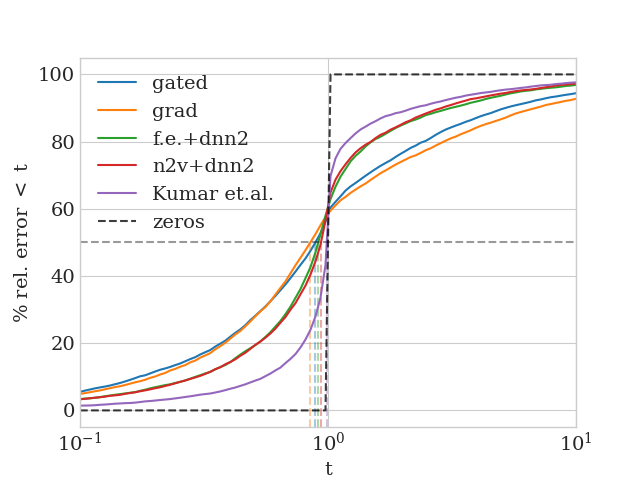

In [149]:
if distribution == "unimodal":
    limits = (-1, 1)
elif graph_name == "complete":
    limits = (-3, 1)
else:
    limits = (-2, 1)
save_path = os.path.join(figures_save_folder, f"rel_error_{graph_name}_{distribution}")
fig, ax, auc = plot_mag_error_curves(val_flow, True, xlim=limits, nsteps=100, **flows)
fig.savefig(save_path + ".pdf", bbox_inches='tight')
tikzplotlib.save(save_path + ".tex")

# Plot flow value histograms

In [150]:
hist_abs_data = pd.DataFrame(
{'gt': np.maximum(np.abs(val_flow), 1e-6),
 'gated': np.maximum(np.abs(flows['gated']), 1e-6),
#   'dnn2': np.maximum(np.abs(flows['dnn2']), 1e-6),
 'grad': np.maximum(np.abs(flows['grad']), 1e-6),
#  'grad (MSE)':  np.maximum(np.abs(flows['grad (MSE)']), 1e-6)
}).melt(var_name='model', value_name="flow value")

<IPython.core.display.Javascript object>


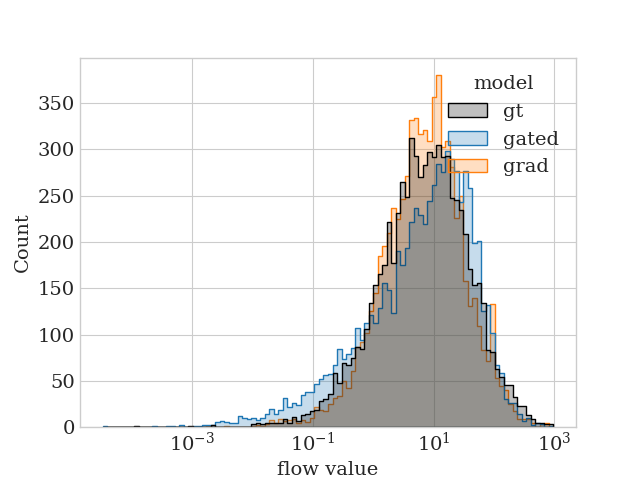

In [151]:
if graph_name == 'complete' and distribution == "unimodal":
    bins = 20
else:
    bins = 100
save_path = os.path.join(figures_save_folder, f"val_flow_abs_hist{graph_name}_{distribution}")
fig, ax = plt.subplots()
g = sns.histplot(hist_abs_data, x="flow value", hue="model",  
                  bins=bins, common_bins=True,
                 kde=False, element="step", log_scale=distribution=='unimodal',
                palette={'gt': 'k', 'gated': default_colors[0], 'grad': default_colors[1]})

fig.savefig(save_path + ".pdf", bbox_inches='tight')
tikzplotlib.save(save_path + ".tex")